# Exercise #2 - Calibrating a Qubit Measurement

In this exercise you will use the parameters we learned about our chip in the tutorial to learn about the readout calibration of our devices.

In [1]:
import sys
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

from qiskit import IBMQ, pulse
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import SchedStyle

if not sys.warnoptions:
    warnings.simplefilter("ignore")

style = SchedStyle(figsize=(6, 3), title_font_size=0, axis_font_size=12, label_font_size=0, icon_font_size=8, 
                   table_font_size=6, table_columns=1)

## First lets load our backend

In [2]:
hub = 'ibm-q-community'
group = 'ieee-session'
project = 'main'
backend_name = 'ibmq_rome'

In [3]:
from qiskit import IBMQ
# Load account credentials
IBMQ.load_account()
# Load provider
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
# Get our backend
backend = provider.get_backend(backend_name)

In [4]:
# configuration - Hardware configuration information.
config = backend.configuration()
# properties - Physical properties of the device.
properties = backend.properties()
# defaults - Information for pulse properties that change frequently.
defaults = backend.defaults()

Then we load our calibrated chip from the tutorial

In [5]:
from chip import Chip

chip = Chip.load('saved_chip_ex2.json')
chip

Chip(Qubit(0, attrs={'w0_1': 4968064556.396592, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.0863890116508783, 'cr45_dur': 560, 'cr45_sigma': 64, 'cr45_width': 304, 'cr45_q0q1_amp': 0.4747837879906288}), Qubit(1, attrs={'w0_1': 4770241521.498985, 'x90_dur': 160, 'x90_sigma': 40, 'x90_amp': 0.06016207217310312, 'cr45_dur': 560, 'cr45_sigma': 64, 'cr45_width': 304}))

# Calibrating Readout 
The readout of a superconducting system is dependent on the readout pulse frequency, amplitude and duration. When calibrating the readout pulse one takes into account these different parameters to get an optimal measurement of the $|0>$ vs $|1>$ state. 

To determine the impact of these values, we will:

1. Fix the pulse amplitude, duration, frequency and timing.  
2. Run an experiment that determines the $|0>$ state centroid position.
3. Excited the qubit into the $|1>$ state and measure the new centroid position.
4. Adjust the readout parameters to separate the two centroids, while avoiding issues arising from decay during readout. 

### First load your x180 pulse 

hint: it will be twice as much rotation as your x90 pulse you calibrated and stored.

In [6]:
# Solution
x180_pulses = []
for qubit in chip.qubits:
    x180 = pulse.Gaussian(qubit.attrs.x90_dur, qubit.attrs.x90_amp*2, qubit.attrs.x90_sigma)
    x180_pulses.append(x180)

## Now write the experiment described above for each qubit

If you're stuck the documentation for [pulse can be found here](https://qiskit.org/documentation/apidoc/pulse.html). The pulse builder documentation is at the [end of the page](https://qiskit.org/documentation/apidoc/pulse.html#pulse-builder-builder), you can always default to using the older `Schedule` interface presented in the [tutorials](https://qiskit.org/documentation/tutorials/pulse/index.html). 

In [7]:
d = lambda qubit: pulse.DriveChannel(qubit)
m = lambda qubit: pulse.MeasureChannel(qubit) 
a = lambda qubit: pulse.AcquireChannel(qubit)
mem_slot = lambda qubit: pulse.MemorySlot(qubit)

In [8]:
# pulse parameters
#meas_duration = 22400
meas_duration = 11200
meas_sigma = 54
meas_width = meas_duration - 320
meas_amp_guess = 0.01
n_exps = 10

scale_factor = 1e-7

In [9]:
def prepare_meas_cal_exp(amp, prep_excited=False):

    meas_pulse = pulse.GaussianSquare(
        duration=meas_duration,
        sigma=meas_sigma,
        amp=amp,
        width=meas_width,
    )

    with pulse.build(backend=backend) as meas_sched:
        if prep_excited:
            pulse.play(x180_pulses[0], d(0))
        
        pulse.barrier(*range(pulse.num_qubits()))
        for qubit in chip.qubits:
            pulse.play(meas_pulse, m(qubit.index))

        for qubit in range(pulse.num_qubits()):
            pulse.acquire(meas_duration, a(qubit), mem_slot(qubit))
    
    return meas_sched
    

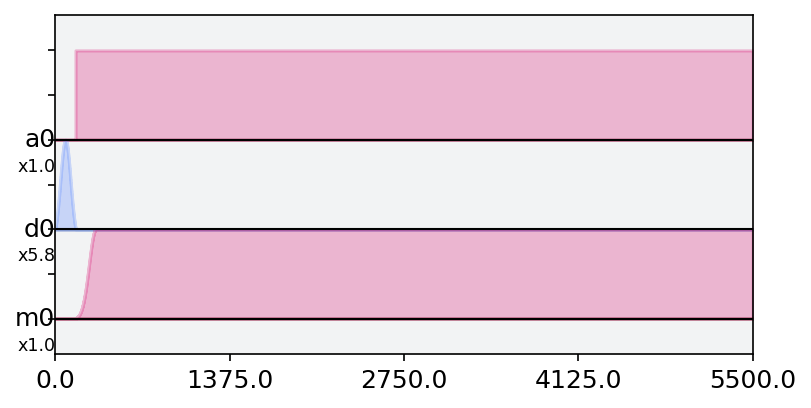

In [10]:
prepare_meas_cal_exp(1.0, prep_excited=True).draw(style=style,plot_range=[0,5500],channels=[d(0),m(0),a(0)])

Running an experiment with `meas_level=1` allows us to get the kernelled data out from the device. This corresponds to the acquired measurement pulse after integration with an optimized weighted kernel on the hardware. The result will be an array of complex values in the IQ plane. These may be extracted.

We can ask for the results for every shot to be returned by using `meas_return="single"` or alternatively we could retrieve the average data with `meas_return="avg"`.

The data for `meas_level=1` is available in the result object under the getter `result.get_memory(i)` for the respective program in the job.

In [11]:
from qiskit import execute
cal_progs = [
    prepare_meas_cal_exp(meas_amp_guess, prep_excited=False),
    prepare_meas_cal_exp(meas_amp_guess, prep_excited=True)
]

readout_job = execute(cal_progs, backend, meas_level=1, meas_return='single')

print(readout_job.job_id())
job_monitor(readout_job)

5f85a67fac44480019b5b04e
Job Status: job has successfully run


In [12]:
readout_result = readout_job.result()

In [13]:
def get_qubit_data(result, prog_idx, qubit):
    """Get the data for a qubit for measurement level 1"""
    return result.get_memory(prog_idx)[:, qubit]*scale_factor

In [14]:
get_qubit_data(readout_result, 0, 0)

array([ 1.2144057+0.1497101j,  0.7157982+0.6315443j,
       -0.0302751-0.333311j , ...,  0.3150233+1.1802943j,
        0.5905954+1.0807756j, -0.7190584+0.7622964j])

In [15]:
# Solution

def calculate_centroid_location(centroid_data):
    """Calculate the centroid location
    
    Hint: We want to look at the "center" of our data
    
    Returns:
        complex: The centroid location.
    """
    return np.mean(centroid_data)

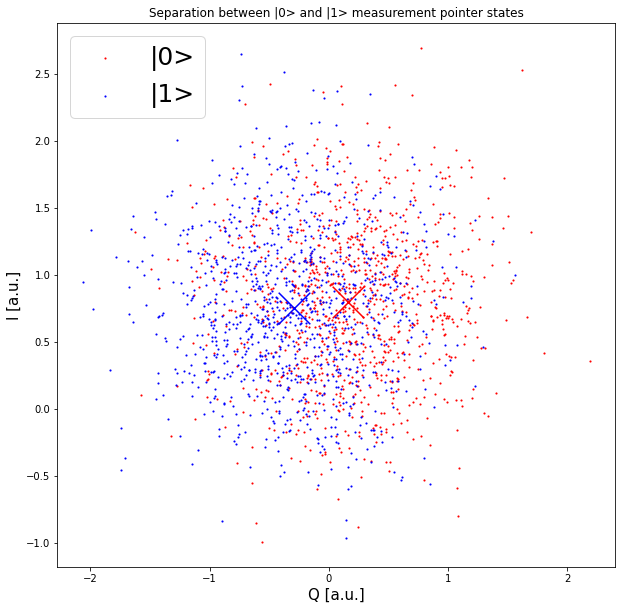

In [16]:
ground = get_qubit_data(readout_result, 0, 0)
excited = get_qubit_data(readout_result, 1, 0)

ground_centroid_location = calculate_centroid_location(ground)
excited_centroid_location = calculate_centroid_location(excited)

plt.figure(figsize=(10,10))

plt.scatter(np.real(ground), np.imag(ground), s=5, color='red', marker='.')
plt.scatter(np.real(excited), np.imag(excited),s=5, color='blue', marker='.')

plt.scatter(np.real(ground_centroid_location), np.imag(ground_centroid_location), color='red', marker='x', s=1000)
plt.scatter(np.real(excited_centroid_location), np.imag(excited_centroid_location), color='blue', marker='x', s=1000)

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("Separation between |0> and |1> measurement pointer states")
plt.legend(["|0>","|1>"],fontsize=25)
plt.show()

We don't get a good separation between our pointer states, how come? Well it's because we haven't calibrated our measurement pulse yet! You'll write this calibration routine below

To do this we'll first need to come up with a metric for how good our pulse is. For now we'll choose the euclidean distance between our two complex valued centroids. With some statistics one can show that this is a relatively good metric for our readout quality. Fill in the method below: 

In [17]:
# Solution

def calculate_centroid_separation(ground_loc, excited_loc):
    """A method to calculate the separation between our centroids
    
    Use the Euclidean distance between these centroid locations.
    
    Returns:
        float: Euclidean distance between our centroids.
    """
    return abs(ground_loc - excited_loc)**2

In [18]:
calculate_centroid_separation(ground_centroid_location, excited_centroid_location)

0.21476928686849647

Now sweep over pulse amplitudes and find the measurement amplitude that maximizes the separation between our measurement pointer states. This will be the calibrated value for our measurement pulse.

In [19]:
max_amp = 0.15
amps = np.linspace(0, max_amp, n_exps)

In [20]:
# Solution
def prep_exps(amps):
    """You should fill in the function below.
    
    Returns:
       A list of pulse schedules with the first `n_exps` being ground reference 
       experiments and the second half of experiments being excited state 
       preparation experiments.
    """
    ground_exps = [prepare_meas_cal_exp(amp, prep_excited=False) for amp in amps]
    excited_exps = [prepare_meas_cal_exp(amp, prep_excited=True) for amp in amps]
    readout_exps = ground_exps+excited_exps
    return readout_exps

In [21]:
readout_cal_job = execute(prep_exps(amps), backend, meas_level=1, meas_return='single')

print(readout_cal_job.job_id())
job_monitor(readout_cal_job)

5f85a69900e634001a20a2c9
Job Status: job has successfully run


Now we'll write a function to calculate the distance between our pointer states for each amplitude we ran above.

In [22]:
# Solution
def calculate_distances(result):
    """Calculate the distance between each ground, excited pair from your experiment.
    
    Reuse the functions we already defined above.

    Returns:
        An array of complex values.
    """
    n_exps = len(result.results)
    centroid_locs = [calculate_centroid_location(get_qubit_data(result, i, 0)) for i in range(n_exps)]
    distances = np.asarray(
        [calculate_centroid_separation(centroid_locs[i], centroid_locs[n_exps//2 + i]) for i in range(n_exps//2)]
    )
    return distances
    

The optimal measurement pulse amplitude is 0.15 a.u.


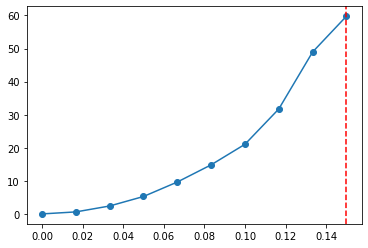

In [23]:
readout_cal_result = readout_cal_job.result()

centroid_distances = calculate_distances(readout_cal_result)
plt.plot(amps, centroid_distances)

optimal_idx = int(np.argmax(centroid_distances))
optimal_amp = amps[optimal_idx]

plt.scatter(amps, centroid_distances)
plt.axvline(optimal_amp, color='red', linestyle='--')
print("The optimal measurement pulse amplitude is {} a.u.".format(optimal_amp))

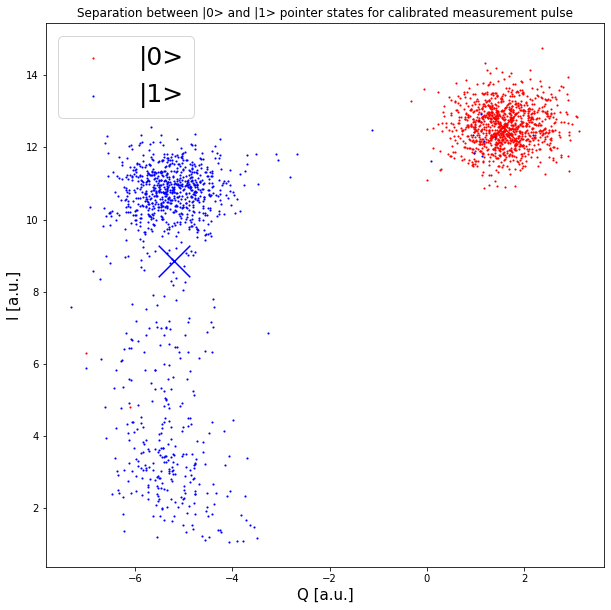

In [24]:
ground = get_qubit_data(readout_cal_result, optimal_idx, 0)
excited = get_qubit_data(readout_cal_result, n_exps+optimal_idx, 0)

ground_centroid_location = calculate_centroid_location(ground)
excited_centroid_location = calculate_centroid_location(excited)

plt.figure(figsize=(10,10))

plt.scatter(np.real(ground), np.imag(ground), s=5, color='red', marker='.')
plt.scatter(np.real(excited), np.imag(excited),s=5, color='blue', marker='.')

plt.scatter(np.real(ground_centroid_location), np.imag(ground_centroid_location), color='red', marker='x', s=1000)
plt.scatter(np.real(excited_centroid_location), np.imag(excited_centroid_location), color='blue', marker='x', s=1000)

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("Separation between |0> and |1> pointer states for calibrated measurement pulse")
plt.legend(["|0>","|1>"],fontsize=25)
plt.show()

# Bonus Exercise
What happens if we keep increasing the power of our measurement pulse in the sweep (re-run the above experiment with a larger `max_amp`)? Do we still only have two clusters? What might these other clusters be?

Hint: Our qubit isn't a perfect qubit :)

What are the downsides to this result? Do the pointer states we prepared still seem well-separated?

# Bonus Exercise
Write a method to determine if an input measurement shot result for qubit 0 is a |0> or a |1> assuming you have fixed your measurement pulse with the calibration routine above. This is known as the measurement state discrimination process. As a next step you could produce the counts dictionary (the output of `meas_level=2`) from the output of `meas_level=1`.

Hint: You should be able to find the line in the complex plane that bisects the calibrated centroids.

In [25]:
def discriminate(qubit_results):
    """This method should pass through the array of qubit IQ results and assign to each value a state 0, or 1.
    
    Returns:
        An array of integers, the qubit measurement result 0 or 1.
    """

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright